In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import network_design as nd
!pip install netrd
import netrd

In [2]:
df_people = pd.read_csv('data/social_networks/broadway/broadway_people.csv',index_col=False)

In [3]:
creatives = ['Written','Directed','Lyrics','Book','Music','Original Music','Choreographed','Book adapted']

In [4]:
df_creatives = df_people[df_people.Role.isin(creatives)]

In [5]:
df_shows = pd.read_csv('data/social_networks/broadway/broadway_show.csv',index_col=False)

In [6]:
valid_shows = pd.unique(df_shows.Season)[-10:]

In [7]:
df_shows = df_shows[df_shows.Season.isin(valid_shows)]

In [11]:
df_musicals = df_shows[df_shows.Type=='Musical']

In [10]:
df_musicals

NameError: name 'df_musicals' is not defined

In [12]:
# Get creatives
df_creatives_10_years = pd.merge(df_musicals,df_creatives,on='Show')
df_creatives_10_years = df_creatives_10_years.replace('Book adapted','Book')
df_creatives_10_years = df_creatives_10_years.replace('Written','Book')

/tmp/ipykernel_24835/1160362963.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_creatives_10_years = df_creatives_10_years.replace('Book adapted','Book')


In [13]:
pd.unique(df_creatives_10_years.Role)

array(['Book', 'Lyrics', 'Music', 'Directed', 'Choreographed'],
      dtype=object)

In [14]:
g = nx.Graph()
g.add_nodes_from(pd.unique(df_creatives_10_years.Person))
g.add_nodes_from(pd.unique(df_creatives_10_years.Show))

In [15]:
particle_types = list(set([tuple(np.sort(pd.unique(df_creatives_10_years[df_creatives_10_years.Person == p].Role))) for p in pd.unique(df_creatives_10_years.Person)])) + ['Show']

In [16]:
particle_types

[('Lyrics', 'Music'),
 ('Directed', 'Lyrics'),
 ('Book', 'Lyrics'),
 ('Book', 'Directed', 'Lyrics', 'Music'),
 ('Choreographed',),
 ('Book', 'Directed'),
 ('Lyrics',),
 ('Book', 'Music'),
 ('Directed',),
 ('Book', 'Choreographed', 'Directed'),
 ('Music',),
 ('Book', 'Lyrics', 'Music'),
 ('Book',),
 ('Choreographed', 'Directed'),
 'Show']

In [17]:
from itertools import combinations
for s in pd.unique(df_creatives_10_years.Show):
    # Get people
    cur_show = df_creatives_10_years[df_creatives_10_years.Show == s]
    people = pd.unique(cur_show.Person)
    # pairs = list(combinations(people,2))
    pairs = [(s,p) for p in people]
    g.add_edges_from(pairs)

In [18]:
for n in list(g.nodes()):
    if len(pd.unique(df_creatives_10_years[df_creatives_10_years.Person == n].Role)) > 1:
        g.remove_node(n)

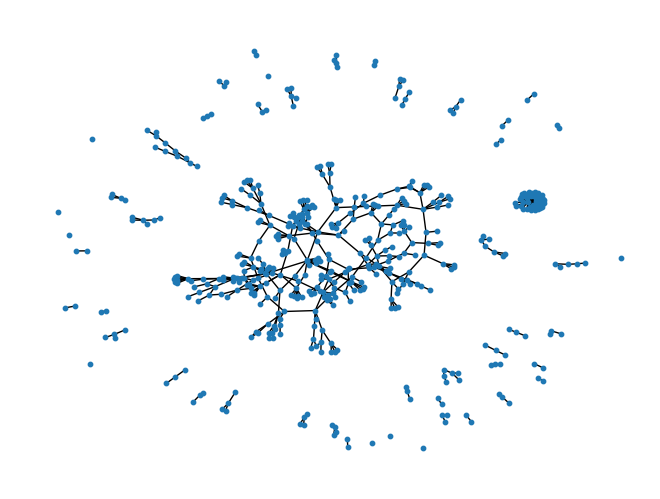

In [19]:
nx.draw(g,node_size=10,width=1)

In [17]:
h = nx.subgraph(g,sorted(list(nx.connected_components(g)),key=len,reverse=True)[0])

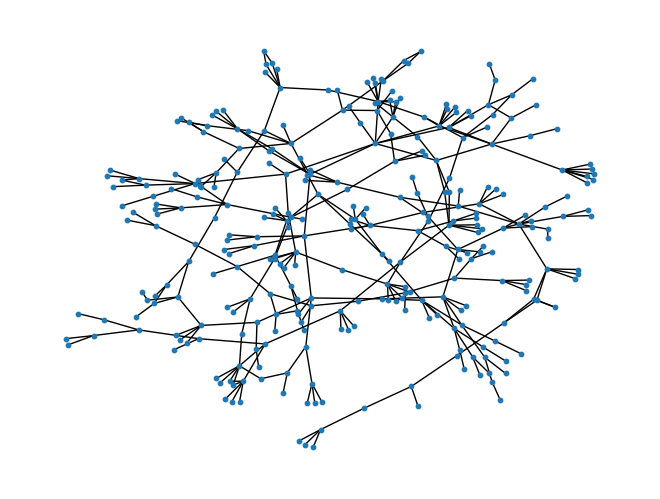

In [18]:
nx.draw(h,node_size=10,width=1)

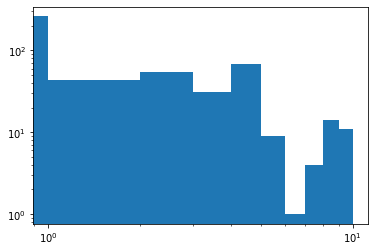

In [83]:
plt.hist(np.array(h.degree())[:,1])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [28]:
vals = np.array(list(dict(nx.pagerank(g)).values()))
names = list(dict(nx.pagerank(g)).keys())

In [29]:
np.array(names)[np.argsort(vals)][::-1]

array(['Forever Tango', 'Kiss Me, Kate',
       'Beautiful The Carole King Musical', 'Hair', 'Warren Carlyle',
       'On the Town', 'The Visit', 'My Fair Lady', 'Christopher Gattelli',
       'Hello, Dolly!', 'Oklahoma!', 'Gigi', 'Jesus Christ Superstar',
       'Frozen', 'The Color Purple', 'Allegiance', 'Company', 'Carousel',
       'The King and I', 'Caroline, or Change', 'Follies',
       'On the Twentieth Century', 'Les Misérables', 'West Side Story',
       'Spider-Man: Turn Off The Dark', 'Anastasia', 'Cabaret',
       'Fiddler on the Roof', 'Harold Prince', 'Side Show',
       'Pretty Woman: The Musical', 'On a Clear Day You Can See Forever',
       'Rocky', 'Beetlejuice', 'The Rascals: Once Upon A Dream', 'Six',
       'Soul Doctor', 'Once', 'First Date', 'Dames at Sea', 'Scandalous',
       'Motown The Musical', "Gettin' The Band Back Together",
       'Finding Neverland', "The Gershwins' Porgy and Bess",
       'Diane Paulus', 'Spring Awakening', 'Sunset Boulevard',
       

In [20]:
particle_types = sorted(particle_types,key=len)[::-1]

In [31]:
type_dict = {p:0 for p in particle_types}
idx_rule = {p:i for i, p in enumerate(particle_types)}
capacities = {i:{j:0 for j in particle_types} for i in particle_types}
people = {p:[] for p in particle_types}
for name in g.nodes():
    # Get name
    try:
        cur_person = df_creatives_10_years[df_creatives_10_years.Person == name]
        roles = tuple(np.sort(pd.unique(cur_person.Role)))
        type_dict[roles] += 1
        people[roles].append(name)
    except:
        type_dict['Show'] += 1
        people['Show'].append(name)

In [32]:
totals = np.array([type_dict[p] for p in idx_rule.keys()])

In [33]:
for p in sorted(particle_types,key=len)[::-1]:
    names = people[p]
    connections = np.zeros(len(particle_types))
    for person in names:
        neighbors = g.neighbors(person)
        for n in neighbors:
            roles = tuple(np.sort(pd.unique(df_creatives_10_years[df_creatives_10_years.Person == n].Role)))
            if roles == ():
                roles = 'Show'
            connections[idx_rule[roles]] += 1
    connections /= totals
    capacities[p] = {c:connections[idx_rule[c]] for c in particle_types}
            

/tmp/ipykernel_24835/1746742205.py:11: RuntimeWarning: invalid value encountered in divide
  connections /= totals


In [34]:
capacities

{'Show': {'Show': 0.8467741935483871,
  ('Book', 'Directed', 'Lyrics', 'Music'): nan,
  ('Book', 'Lyrics', 'Music'): nan,
  ('Book', 'Choreographed', 'Directed'): nan,
  ('Choreographed', 'Directed'): nan,
  ('Book', 'Music'): nan,
  ('Book', 'Directed'): nan,
  ('Book', 'Lyrics'): nan,
  ('Directed', 'Lyrics'): nan,
  ('Lyrics', 'Music'): nan,
  ('Book',): nan,
  ('Music',): 1.8125,
  ('Directed',): 1.6063829787234043,
  ('Lyrics',): 1.45,
  ('Choreographed',): 1.2952380952380953},
 ('Book', 'Directed', 'Lyrics', 'Music'): {'Show': 0.0,
  ('Book', 'Directed', 'Lyrics', 'Music'): nan,
  ('Book', 'Lyrics', 'Music'): nan,
  ('Book', 'Choreographed', 'Directed'): nan,
  ('Choreographed', 'Directed'): nan,
  ('Book', 'Music'): nan,
  ('Book', 'Directed'): nan,
  ('Book', 'Lyrics'): nan,
  ('Directed', 'Lyrics'): nan,
  ('Lyrics', 'Music'): nan,
  ('Book',): nan,
  ('Music',): 0.0,
  ('Directed',): 0.0,
  ('Lyrics',): 0.0,
  ('Choreographed',): 0.0},
 ('Book', 'Lyrics', 'Music'): {'Show': 0

In [25]:
# Get rule
# particle_types = ['Show','Book','Directed','Lyrics','Music','Choreographed']
idx_rule = {p:i for i, p in enumerate(particle_types)}
capacities = {i:{j:0 for j in particle_types} for i in particle_types}
all_people = np.array([])
for p in sorted(particle_types,key=len)[::-1]:
    if p == 'Show':
        uniq_part = pd.unique(df_creatives_10_years[p])
    else:
        for i, label in enumerate(p):
            if i == 0:
                # Get unique particles
                uniq_part = pd.unique(df_creatives_10_years[df_creatives_10_years.Role == label].Person)
                idx = list(df_creatives_10_years[df_creatives_10_years.Role == label].index)
                df_creatives_10_years.drop(idx,axis=0,inplace=True)
            else:
                cur_df = df_creatives_10_years[df_creatives_10_years.Person.isin(uniq_part)]
                # Get unique particles
                uniq_part = pd.unique(cur_df[cur_df.Role == label].Person)
                idx = list(cur_df[cur_df.Role == label].index)
                df_creatives_10_years.drop(idx,axis=0,inplace=True)
    connections = np.zeros(len(particle_types))
    for obj in uniq_part:
        # Get neighbors
        neighbors = g.neighbors(obj)
        for n in neighbors:
            roles = tuple(np.sort(pd.unique(df_creatives_10_years[df_creatives_10_years.Person == n].Role)))
            if roles == ():
                roles = 'Show'
            connections[idx_rule[roles]] += 1
    connections /= len(uniq_part)
    capacities[p] = {c:connections[idx_rule[c]] for c in particle_types}
# for s in pd.unique(df_musicals.Show):
# print(capacities)
    

NetworkXError: The node Lucy Moss is not in the graph.

In [35]:
O = np.zeros((len(capacities.keys()),len(capacities.keys())))
for i in capacities.keys():
    for j in capacities.keys():
        O[i,j] = capacities[i][j]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [27]:
new_capacities = {idx_rule[p]:{idx_rule[q]:capacities[p][q] for q in particle_types} for p in particle_types}

In [145]:
N_vec

array([158,   1,   1,  19,   1,  27,  25,   2,  15,  55, 105,  32,  94,
        90,  20])

In [228]:
type_dict = {p:0 for p in particle_types}
for name in g.nodes():
    # Get name
    try:
        cur_person = df_creatives_10_years[df_creatives_10_years.Person == name]
        roles = tuple(np.sort(pd.unique(cur_person.Role)))
        type_dict[roles] += 1
    except:
        type_dict['Show'] += 1

In [28]:
type_dict

{'Show': 158,
 ('Book', 'Directed', 'Lyrics', 'Music'): 0,
 ('Book', 'Lyrics', 'Music'): 0,
 ('Book', 'Choreographed', 'Directed'): 0,
 ('Choreographed', 'Directed'): 0,
 ('Book', 'Music'): 0,
 ('Book', 'Directed'): 0,
 ('Book', 'Lyrics'): 0,
 ('Directed', 'Lyrics'): 0,
 ('Lyrics', 'Music'): 0,
 ('Book',): 90,
 ('Music',): 32,
 ('Directed',): 94,
 ('Lyrics',): 20,
 ('Choreographed',): 105}

In [29]:
capacities

{'Show': {'Show': 0,
  ('Book', 'Directed', 'Lyrics', 'Music'): 0,
  ('Book', 'Lyrics', 'Music'): 0,
  ('Book', 'Choreographed', 'Directed'): 0,
  ('Choreographed', 'Directed'): 0,
  ('Book', 'Music'): 0,
  ('Book', 'Directed'): 0,
  ('Book', 'Lyrics'): 0,
  ('Directed', 'Lyrics'): 0,
  ('Lyrics', 'Music'): 0,
  ('Book',): 0,
  ('Music',): 0,
  ('Directed',): 0,
  ('Lyrics',): 0,
  ('Choreographed',): 0},
 ('Book', 'Directed', 'Lyrics', 'Music'): {'Show': 0,
  ('Book', 'Directed', 'Lyrics', 'Music'): 0,
  ('Book', 'Lyrics', 'Music'): 0,
  ('Book', 'Choreographed', 'Directed'): 0,
  ('Choreographed', 'Directed'): 0,
  ('Book', 'Music'): 0,
  ('Book', 'Directed'): 0,
  ('Book', 'Lyrics'): 0,
  ('Directed', 'Lyrics'): 0,
  ('Lyrics', 'Music'): 0,
  ('Book',): 0,
  ('Music',): 0,
  ('Directed',): 0,
  ('Lyrics',): 0,
  ('Choreographed',): 0},
 ('Book', 'Lyrics', 'Music'): {'Show': 0,
  ('Book', 'Directed', 'Lyrics', 'Music'): 0,
  ('Book', 'Lyrics', 'Music'): 0,
  ('Book', 'Choreographed',

In [211]:
type_dict

{('Book', 'Directed', 'Lyrics', 'Music'): 1,
 'Show': 158,
 ('Book', 'Lyrics', 'Music'): 19,
 ('Book', 'Choreographed', 'Directed'): 1,
 ('Lyrics', 'Music'): 55,
 ('Book', 'Directed'): 15,
 ('Book', 'Music'): 2,
 ('Choreographed', 'Directed'): 25,
 ('Book', 'Lyrics'): 27,
 ('Directed', 'Lyrics'): 1,
 ('Lyrics',): 20,
 ('Book',): 90,
 ('Directed',): 94,
 ('Music',): 32,
 ('Choreographed',): 105}

In [231]:
X = np.zeros((g.number_of_nodes(),len(particle_types)))
total = 0
for k,p in enumerate(particle_types):
    uniq_part = type_dict[p]
    X[total:(total + uniq_part),k] = 1
    total += uniq_part
    

In [232]:
X.sum(axis=0)

array([158.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 105.,
        32.,  94.,  90.,  20.])

In [233]:
O = np.zeros((len(particle_types),len(particle_types)))
for i in range(len(particle_types)):
    for j in range(len(particle_types)):
        O[i,j] = new_capacities[i][j]

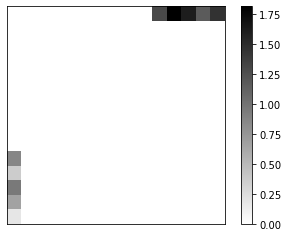

In [234]:
plt.imshow(O,cmap='binary')
plt.xticks([])
plt.yticks([])
plt.colorbar()

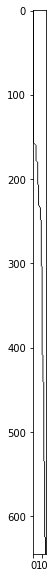

In [71]:
plt.figure(figsize=(500,10))
plt.imshow(X,cmap='binary')


In [138]:
N_vec = X.sum(axis=0).astype(int)
N = np.sum(N_vec)
# Generate probability matrix
P = np.zeros((N,N))
# if directed:
#     for i in range(N):
#         for j in range(N):
#             # Get labels of nodes
#             theta_i = np.where(X[i]==1)[0][0]
#             theta_j = np.where(X[j]==1)[0][0]
#             P[i,j] = O[theta_i,theta_j] / N_vec[theta_j]
# else:
for i in range(N):
    for j in range(i,N):
        # Get labels of nodes
        theta_i = np.where(X[i]==1)[0][0]
        theta_j = np.where(X[j]==1)[0][0]
        P[i,j] = np.min([1,np.min([O[theta_i,theta_j]/N_vec[theta_j],O[theta_j,theta_i]/N_vec[theta_i]])])
    

In [144]:
P

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [283]:
new_g = nd.canonical_ensemble(X.sum(axis=0).astype(int),O,X)

In [264]:
new_g = nd.new_soup_of_nodes(X,nd.create_capacity(X,new_capacities),self_loops=False)

In [209]:
new_capacities

{0: {0: np.float64(0.0),
  1: np.float64(0.006329113924050633),
  2: np.float64(0.0),
  3: np.float64(0.0),
  4: np.float64(0.0),
  5: np.float64(0.0),
  6: np.float64(0.0),
  7: np.float64(0.0),
  8: np.float64(0.0),
  9: np.float64(0.0),
  10: np.float64(0.0),
  11: np.float64(0.0),
  12: np.float64(0.0),
  13: np.float64(0.0),
  14: np.float64(0.0)},
 1: {0: np.float64(1.0),
  1: np.float64(0.0),
  2: np.float64(1.1578947368421053),
  3: np.float64(2.0),
  4: np.float64(1.2727272727272727),
  5: np.float64(1.8),
  6: np.float64(1.5),
  7: np.float64(2.76),
  8: np.float64(1.6296296296296295),
  9: np.float64(1.0),
  10: np.float64(1.45),
  11: np.float64(1.1666666666666667),
  12: np.float64(1.6063829787234043),
  13: np.float64(1.8125),
  14: np.float64(1.2952380952380953)},
 2: {0: np.float64(0.0),
  1: np.float64(0.13924050632911392),
  2: np.float64(0.0),
  3: np.float64(0.0),
  4: np.float64(0.0),
  5: np.float64(0.0),
  6: np.float64(0.0),
  7: np.float64(0.0),
  8: np.float64

In [270]:
idx_rule

{'Show': 0,
 ('Book', 'Directed', 'Lyrics', 'Music'): 1,
 ('Book', 'Choreographed', 'Directed'): 2,
 ('Book', 'Lyrics', 'Music'): 3,
 ('Directed', 'Lyrics'): 4,
 ('Book', 'Lyrics'): 5,
 ('Choreographed', 'Directed'): 6,
 ('Book', 'Music'): 7,
 ('Book', 'Directed'): 8,
 ('Lyrics', 'Music'): 9,
 ('Choreographed',): 10,
 ('Music',): 11,
 ('Directed',): 12,
 ('Book',): 13,
 ('Lyrics',): 14}

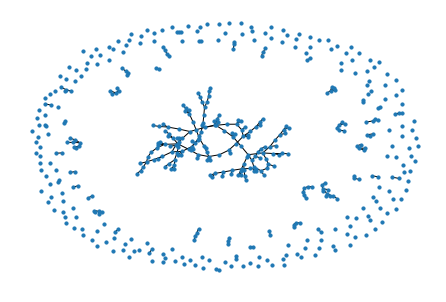

In [271]:
nx.draw(new_g,node_size=10,width=1)

In [284]:
new_h = nx.subgraph(new_g,sorted(list(nx.connected_components(new_g)),key=len,reverse=True)[0])

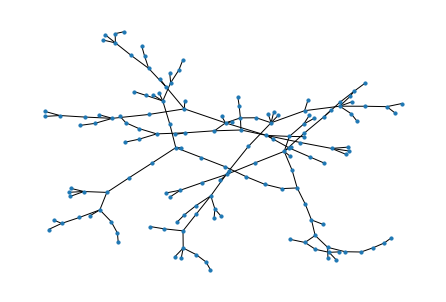

In [285]:
nx.draw(new_h,node_size=10,width=1)

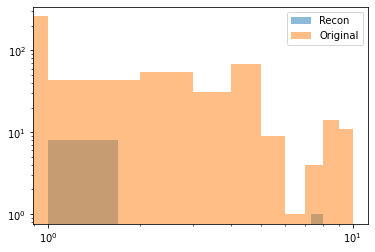

In [200]:
plt.hist(np.array(new_h.degree())[:,1],alpha=.5,label='Recon')
plt.xscale('log')
plt.yscale('log')
plt.hist(np.array(h.degree())[:,1],alpha=.5,label='Original')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [215]:
print(np.array(list(dict(nx.average_neighbor_degree(g)).values())).mean(),np.array(list(dict(nx.average_neighbor_degree(new_g)).values())).mean())

6.775130709084198 2.7731890966021826


In [216]:
print(nx.average_shortest_path_length(h),nx.average_shortest_path_length(new_h))

7.76133911905166 7.9214801187819734


In [217]:
nx.write_edgelist(nx.convert_node_labels_to_integers(g),'data/social_networks/broadway/ex1/g.txt')

In [218]:
nx.write_edgelist(nx.convert_node_labels_to_integers(new_g),'data/social_networks/broadway/ex1/new_g.txt')

In [177]:
from portrait_divergence import portrait_divergence

In [281]:
portrait_divergence(g,new_g)

np.float64(0.595194863785613)

In [208]:
nx.configuration_model(np.array(g.degree())[:,1].astype('int'))

In [278]:
portrait_divergence(h,nx.configuration_model(np.array(h.degree())[:,1].astype('int')))

np.float64(0.5364518390798572)

In [282]:
portrait_divergence(g,nx.configuration_model(np.array(g.degree())[:,1].astype('int')))

np.float64(0.6367068384458824)

In [286]:
from scipy.spatial.distance import *

In [294]:
hamming(nx.adjacency_matrix(g).toarray().flatten(),nx.adjacency_matrix(new_g).toarray().flatten())

np.float64(0.005983911711197947)

In [296]:
portrait_divergence(h,new_h)

np.float64(0.5780612233180862)

In [300]:
jaccard(nx.adjacency_matrix(g).toarray().flatten(),nx.adjacency_matrix(nx.configuration_model(np.array(g.degree())[:,1].astype('int'))).toarray().flatten())

np.float64(0.9915478077126255)

In [301]:
x = [hamming(nx.adjacency_matrix(g).toarray().flatten(),nx.adjacency_matrix(new_g).toarray().flatten()),
     jaccard(nx.adjacency_matrix(g).toarray().flatten(),nx.adjacency_matrix(new_g).toarray().flatten()),
     portrait_divergence(g,new_g)]

In [302]:
y = [hamming(nx.adjacency_matrix(g).toarray().flatten(),nx.adjacency_matrix(nx.configuration_model(np.array(g.degree())[:,1].astype('int'))).toarray().flatten()),
     jaccard(nx.adjacency_matrix(g).toarray().flatten(),nx.adjacency_matrix(nx.configuration_model(np.array(g.degree())[:,1].astype('int'))).toarray().flatten()),
     portrait_divergence(g,nx.configuration_model(np.array(g.degree())[:,1].astype('int')))]

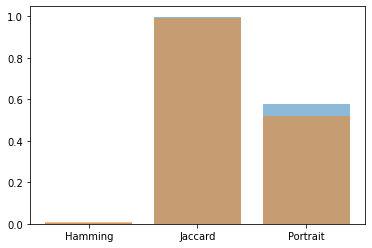

In [305]:
plt.bar([0,1,2],x,alpha=.5)
plt.bar([0,1,2],y,alpha=.5)
plt.xticks([0,1,2],['Hamming','Jaccard','Portrait'])
plt.show()